In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, default_data_collator
from peft import prepare_model_for_kbit_training
import requests
import re
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

# Download Shakespeare text
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
shakespeare_text = response.text

# Tokenization
def tokenize(text):
    return re.findall(r"\b\w+\b|[^\w\s]", text.lower())

tokens = tokenize(shakespeare_text)

# Initialize tokenizer and model
model_name = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load the model with 4-bit quantization
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
)

# Tokenize Shakespeare text
encoded_text = tokenizer.encode(" ".join(tokens), return_tensors="pt")

# Function to add LoRA to a linear layer and replace the original layer
def add_lora_to_linear_and_replace(layer):
    in_features, out_features = layer.in_features, layer.out_features
    
    # Get the dtype of the original layer
    if isinstance(layer, bnb.nn.Linear4bit):
        dtype = layer.compute_dtype
    else:
        dtype = layer.weight.dtype

    # LoRA Layer with correct input-output dimensions and matching dtype
    lora_layer = LoRALayer(in_features, out_features, dtype=dtype)

    # Combine the original layer and LoRA layer
    class CombinedLayer(nn.Module):
        def __init__(self, base_layer, lora_layer):
            super().__init__()
            self.base_layer = base_layer
            self.lora_layer = lora_layer

        def forward(self, x):
            return self.base_layer(x) + self.lora_layer(x)

    combined_layer = CombinedLayer(layer, lora_layer)
    # Ensure the combined layer is on the same device as the original layer
    combined_layer = combined_layer.to(layer.weight.device)
    return combined_layer

# Custom LoRA layer with proper dimension handling
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=128, alpha=64, dtype=torch.float16):
        super().__init__()
        # Initialize parameters with the specified dtype
        self.lora_A = nn.Parameter(torch.randn(in_features, rank, dtype=dtype) / rank)
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features, dtype=dtype) / rank)
        self.scaling = alpha / rank

    def forward(self, x):
        # Ensure input tensor is the same dtype as LoRA parameters
        if x.dtype != self.lora_A.dtype:
            x = x.to(self.lora_A.dtype)
        return (x @ self.lora_A @ self.lora_B) * self.scaling


# Apply LoRA to the last N layers by replacing the original ones
def replace_with_lora_layers_last_n(model, n_layers_to_modify=10):
    count = 0
    # Reverse the list of modules so we start from the end
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, (nn.Linear, bnb.nn.Linear4bit)) and "lm_head" not in name:
            parent_name = name.rsplit(".", 1)[0]  # Get the parent module's name
            parent_module = model.get_submodule(parent_name) if parent_name else model
            child_name = name.split(".")[-1]      # Get the child module's name (layer)

            # Replace the original layer with the LoRA-augmented layer
            print(f"Replacing {child_name} in {parent_name} with LoRA-enhanced layer")
            setattr(parent_module, child_name, add_lora_to_linear_and_replace(module))

            count += 1
            if count >= n_layers_to_modify:  # Stop after replacing N layers
                break

# Apply the layer replacement to the last N layers in the base model
replace_with_lora_layers_last_n(base_model, n_layers_to_modify=6)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Replacing down_proj in model.layers.17.mlp with LoRA-enhanced layer
Replacing up_proj in model.layers.17.mlp with LoRA-enhanced layer
Replacing gate_proj in model.layers.17.mlp with LoRA-enhanced layer
Replacing o_proj in model.layers.17.self_attn with LoRA-enhanced layer
Replacing v_proj in model.layers.17.self_attn with LoRA-enhanced layer
Replacing k_proj in model.layers.17.self_attn with LoRA-enhanced layer


In [2]:
# Prepare model for k-bit training (if applicable and the function is available)
base_model = prepare_model_for_kbit_training(base_model)

# Freeze base model parameters
def set_lora_parameters_trainable(model):
    for name, param in model.named_parameters():
        if "lora" in name.lower():
            param.requires_grad = True
            print(f"LoRA parameter: {name}")

# Call the function at the end
set_lora_parameters_trainable(base_model)

def sanity_check_lora_params(model):
    lora_params_count = 0
    lora_params_require_grad_count = 0
    
    for name, param in model.named_parameters():
        if "lora" in name.lower():
            lora_params_count += 1
            if param.requires_grad:
                lora_params_require_grad_count += 1
    
    print(f"Total LoRA parameters: {lora_params_count}")
    print(f"LoRA parameters with requires_grad=True: {lora_params_require_grad_count}")
    
    if lora_params_count == lora_params_require_grad_count:
        print("Sanity check passed: All LoRA parameters require gradients.")
    else:
        print("Sanity check failed: Not all LoRA parameters require gradients.")

# Run the sanity check
sanity_check_lora_params(base_model)


LoRA parameter: model.layers.17.self_attn.k_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.self_attn.k_proj.lora_layer.lora_B
LoRA parameter: model.layers.17.self_attn.v_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.self_attn.v_proj.lora_layer.lora_B
LoRA parameter: model.layers.17.self_attn.o_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.self_attn.o_proj.lora_layer.lora_B
LoRA parameter: model.layers.17.mlp.gate_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.mlp.gate_proj.lora_layer.lora_B
LoRA parameter: model.layers.17.mlp.up_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.mlp.up_proj.lora_layer.lora_B
LoRA parameter: model.layers.17.mlp.down_proj.lora_layer.lora_A
LoRA parameter: model.layers.17.mlp.down_proj.lora_layer.lora_B
Total LoRA parameters: 12
LoRA parameters with requires_grad=True: 12
Sanity check passed: All LoRA parameters require gradients.


In [3]:
# Dataset class
class ShakespeareDataset(Dataset):
    def __init__(self, encoded_text, seq_length):
        self.encoded_text = encoded_text
        self.seq_length = seq_length

    def __len__(self):
        return len(self.encoded_text[0]) - self.seq_length

    def __getitem__(self, idx):
        return {
            "input_ids": self.encoded_text[0][idx:idx+self.seq_length],
            "labels": self.encoded_text[0][idx+1:idx+self.seq_length+1]
        }
losses = []

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_model.to(device)
base_model.train()

You shouldn't move a model that is dispatched using accelerate hooks.


Using device: cuda


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-16): 17 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Gemma

In [5]:
# Enable gradient checkpointing
base_model.gradient_checkpointing_enable()

#sanity_check_lora_params(base_model)
# vocab_size = tokenizer.vocab_size
# base_model.resize_token_embeddings(vocab_size)


# Hyperparameters
learning_rate = 2e-4  # Increased from previous value
batch_size = 1
gradient_accumulation_steps = 4
num_epochs = 3
warmup_steps = 100  # Add warmup steps
seq_length = 2800
max_grad_norm = 1.0

# Prepare optimizer
from transformers import AdamW, get_linear_schedule_with_warmup

# Filter for LoRA parameters
lora_params = [p for n, p in base_model.named_parameters() if "lora" in n.lower()]
# Create optimizer for LoRA weights only
optimizer = AdamW(lora_params, lr=learning_rate)

print(f"Number of LoRA parameters being optimized: {len(lora_params)}")


# Create dataset and dataloader
dataset = ShakespeareDataset(encoded_text, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=default_data_collator)

# Prepare scheduler
total_steps = len(dataloader) * num_epochs // gradient_accumulation_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# base_model = torch.compile(base_model)
for epoch in range(num_epochs):
    total_loss = 0
    for idx, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = base_model(**batch)
        loss = outputs.loss / gradient_accumulation_steps  # Normalize the loss
        loss.backward()
        
        # Check which parameters the optimizer is updating
        # if (idx + 1) % gradient_accumulation_steps == 0:
        #     print("Parameters being updated:")
        #     for name, param in base_model.named_parameters():
        #         if param.requires_grad is True:
        #             print(f"- {name}")
        #     print("Gradient accumulation step complete. Updating weights.")
        
        # Apply gradient clipping
        #torch.nn.utils.clip_grad_norm_(base_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()

        losses.append(loss.item())

        if idx % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training completed!")

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Number of LoRA parameters being optimized: 12
Epoch 1/3, Batch 1/276810, Loss: 2.0732
Epoch 1/3, Batch 51/276810, Loss: 1.6697
Epoch 1/3, Batch 101/276810, Loss: 1.4761
Epoch 1/3, Batch 151/276810, Loss: 1.4698
Epoch 1/3, Batch 201/276810, Loss: 1.4010
Epoch 1/3, Batch 251/276810, Loss: 1.4930
Epoch 1/3, Batch 301/276810, Loss: 1.2550
Epoch 1/3, Batch 351/276810, Loss: 1.4185
Epoch 1/3, Batch 401/276810, Loss: 1.3671
Epoch 1/3, Batch 451/276810, Loss: 1.3216
Epoch 1/3, Batch 501/276810, Loss: 1.4415


KeyboardInterrupt: 

In [ ]:
# Check LoRA weight statistics
def print_lora_stats(model):
    lora_params = [p for n, p in model.named_parameters() if 'lora_B' in n]
    if lora_params:
        lora_weights = torch.cat([p.view(-1) for p in lora_params])
        print(f"LoRA weights mean: {lora_weights.mean().item():.6f}")
        print(f"LoRA weights std: {lora_weights.std().item():.6f}")
    else:
        print("No LoRA weights found in the model.")

print("LoRA weight statistics after training:")
print_lora_stats(base_model)

LoRA weight statistics after training:
LoRA weights mean: -0.000036
LoRA weights std: 0.009470


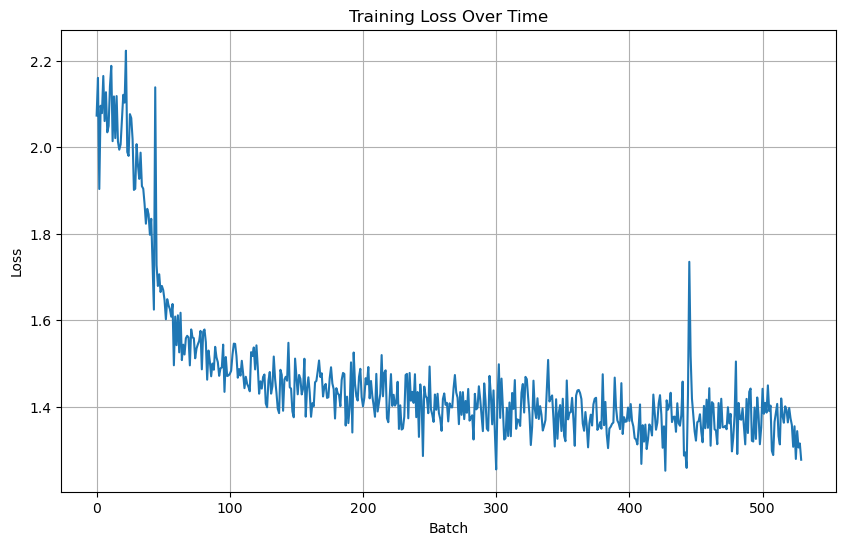

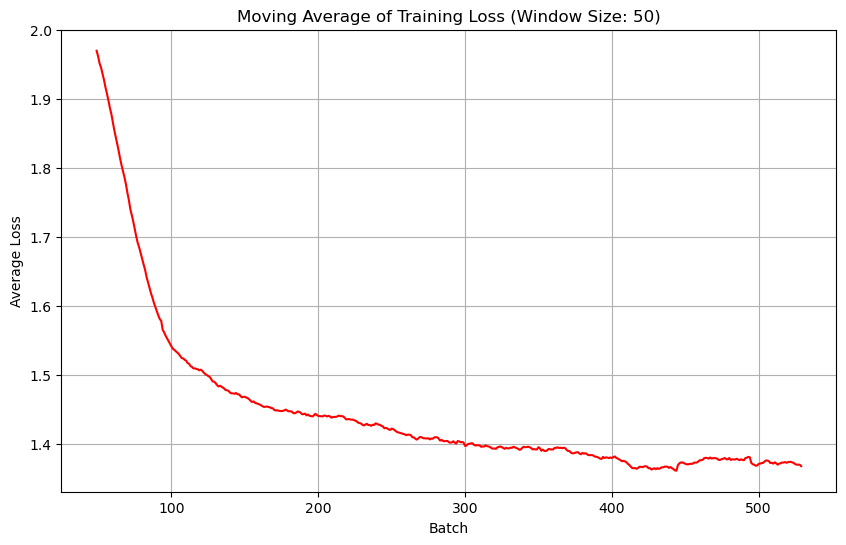

In [6]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Calculate and plot the moving average of the loss
window_size = 50  # Adjust this value to change the smoothing
moving_avg = [sum(losses[i:i+window_size])/window_size for i in range(len(losses)-window_size+1)]

plt.figure(figsize=(10, 6))
plt.plot(range(window_size-1, len(losses)), moving_avg, color='red')
plt.title(f'Moving Average of Training Loss (Window Size: {window_size})')
plt.xlabel('Batch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


In [7]:
def generate_text(model, tokenizer, prompt, max_length=100, temperature=0.7, top_p=0.9, top_k=50):
    """
    Generate text using the fine-tuned model.
    
    :param model: The fine-tuned model
    :param tokenizer: The tokenizer associated with the model
    :param prompt: The input prompt to start generation
    :param max_length: Maximum length of the generated text (including prompt)
    :param temperature: Controls randomness in generation. Lower values make it more deterministic.
    :param top_p: Nucleus sampling parameter
    :param top_k: Top-k sampling parameter
    :return: Generated text as a string
    """
    # Encode the prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return generated_text

# Example usage:
prompt = "To be or not to be "
generated_text = generate_text(base_model, tokenizer, prompt, max_length=200)
print(generated_text)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


To be or not to be <i>Ale :</i> that in life all is ; it a not so is ; that the in life not so and the a to a no . : of a of are not and life no the and , : the and the the , the , : , the . the and not life that but life be the the . if , not the so and life ' ; ' , the to . , a but life . ' life , , . , . , , the . , . , . the ' life and , the and a not life the but not life life and , life and life , , and and . , , that life . , , the life : and the it life and . if ' , if the . the if and it life life but . life all and life and life and life and the and the , , , life if not life . , and , , life if and , the if . , , and . it is and
